<a href="https://colab.research.google.com/github/DemonHunterz9/DL/blob/main/DL6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [17]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

In [18]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [19]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))
train_ds[0].shape


TensorShape([150, 150, 3])

In [20]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [22]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

In [23]:
## We will not train base model i.e. Freeze Parameters in model's lower convolutional layers
base_model.trainable = False

In [24]:
## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [25]:
## model details
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [28]:
history=model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.2797 - loss: 2.2778 - val_accuracy: 0.3288 - val_loss: 1.4386
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.3630 - loss: 1.3563 - val_accuracy: 0.4650 - val_loss: 1.3193
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.4775 - loss: 1.2301 - val_accuracy: 0.4514 - val_loss: 1.3066
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5189 - loss: 1.1761 - val_accuracy: 0.5584 - val_loss: 1.2260
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5809 - loss: 1.0226 - val_accuracy: 0.5778 - val_loss: 1.1545
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.6438 - loss: 0.8836 - val_accuracy: 0.5856 - val_loss: 1.2071
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.6509 - loss: 0.8692 - val_accuracy: 0.6148 - val_loss: 1.1616
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.6910 - loss: 0.8425 - val_accuracy: 0

In [29]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7346 - loss: 0.6426
Loss:  0.6507132649421692 Accuracy:  0.7375113368034363


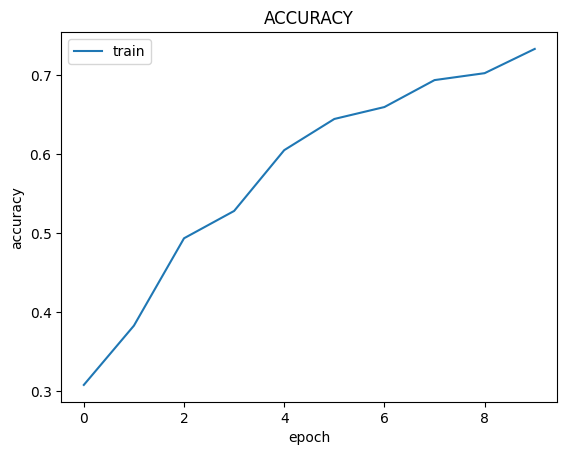

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()